# Cas Pratique : Maintenance Prédictive Automobile

## Objectifs
- Construire un modèle de Machine Learning pour prédire des pannes
- Comprendre le processus end-to-end d'un projet ML
- Évaluer la performance avec des métriques appropriées
- Identifier les véhicules à risque

## Contexte
Nous allons prédire les défaillances de batterie dans les 30 prochains jours à partir de données de télémétrie.

## 1. Configuration et imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

print("✅ Imports réussis")

✅ Imports réussis


## 2. Génération de données simulées

Pour cet exercice, nous allons simuler des données de télémétrie de batteries.

In [2]:
# Paramètres de simulation
np.random.seed(42)
n_vehicles = 5000

print(f"🚗 Simulation de {n_vehicles:,} véhicules")

🚗 Simulation de 5,000 véhicules


In [3]:
# Génération des données
data = []

for vehicle_id in range(1, n_vehicles + 1):
    # Caractéristiques du véhicule
    battery_age = np.random.randint(1, 12)  # Âge batterie en années
    vehicle_age = battery_age + np.random.randint(0, 3)  # Véhicule peut être plus vieux
    
    # Métriques de la batterie
    # Plus la batterie est vieille, plus le voltage est faible et instable
    base_voltage = 12.6 - (battery_age * 0.08) + np.random.normal(0, 0.15)
    voltage = np.clip(base_voltage, 10.5, 13.0)
    
    # Cycles de charge (augmentent avec l'âge)
    charge_cycles = battery_age * np.random.randint(300, 500)
    
    # Température moyenne (impact de l'environnement)
    avg_temperature = np.random.choice([15, 20, 25, 30, 35], p=[0.1, 0.3, 0.3, 0.2, 0.1])
    
    # Utilisation journalière
    daily_starts = np.random.randint(1, 15)
    
    # Kilométrage total
    mileage = vehicle_age * np.random.randint(8000, 25000)
    
    # Indicateur de maintenance régulière (0 ou 1)
    regular_maintenance = np.random.choice([0, 1], p=[0.3, 0.7])
    
    # Déterminer si la batterie va tomber en panne
    # Règles:
    # - Haute probabilité si voltage < 11.5V ET âge > 6 ans
    # - Haute probabilité si cycles > 3000 ET température > 30°C
    # - Basse probabilité si maintenance régulière ET batterie < 4 ans
    
    failure_score = 0
    
    if voltage < 11.5:
        failure_score += 3
    if battery_age > 6:
        failure_score += 2
    if charge_cycles > 3000:
        failure_score += 2
    if avg_temperature > 30:
        failure_score += 1
    if regular_maintenance == 0:
        failure_score += 1
    if daily_starts > 10:
        failure_score += 1
    
    # Probabilité de panne basée sur le score
    failure_prob = min(failure_score / 10, 0.9)
    will_fail = np.random.random() < failure_prob
    
    data.append({
        'vehicle_id': vehicle_id,
        'battery_age': battery_age,
        'vehicle_age': vehicle_age,
        'voltage': round(voltage, 2),
        'charge_cycles': charge_cycles,
        'avg_temperature': avg_temperature,
        'daily_starts': daily_starts,
        'mileage': mileage,
        'regular_maintenance': regular_maintenance,
        'failure': int(will_fail)
    })

# Créer le DataFrame
df = pd.DataFrame(data)

print(f"✅ Dataset créé : {len(df):,} véhicules")
print(f"\n📊 Distribution des pannes :")
print(df['failure'].value_counts())
print(f"\n📈 Taux de pannes : {df['failure'].mean()*100:.1f}%")

✅ Dataset créé : 5,000 véhicules

📊 Distribution des pannes :
failure
0    3791
1    1209
Name: count, dtype: int64

📈 Taux de pannes : 24.2%


In [4]:
# Aperçu des données
print("📋 Aperçu du dataset :")
display(df.head(10))

print("\n📊 Statistiques descriptives :")
display(df.describe())

📋 Aperçu du dataset :


,vehicle_id,battery_age,vehicle_age,voltage,charge_cycles,avg_temperature,daily_starts,mileage,regular_maintenance,failure
0,1,7,7,12.12,2240,20,3,86982,1,0
1,2,8,10,11.87,3592,15,8,104330,0,1
2,3,10,11,11.43,4870,20,14,121055,0,1
3,4,9,11,11.97,3150,25,9,247522,0,0
4,5,2,3,12.35,766,20,12,71361,1,1
5,6,1,2,12.48,403,30,14,39306,0,0
6,7,2,3,12.11,626,30,8,46887,0,1
7,8,8,8,11.80,3048,25,8,161480,1,0
8,9,9,9,11.97,4158,30,11,125028,1,0
9,10,7,7,12.17,2597,25,1,73178,1,0



📊 Statistiques descriptives :


,vehicle_id,battery_age,vehicle_age,voltage,charge_cycles,avg_temperature,daily_starts,mileage,regular_maintenance,failure
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,6.041600,7.04260,12.115508,2411.867800,24.508000,7.508200,116322.346000,0.693600,0.241800
std,1443.520003,3.157889,3.24168,0.290604,1316.081878,5.712658,4.003841,65372.385121,0.461044,0.428217
min,1.000000,1.000000,1.00000,11.130000,300.000000,15.000000,1.000000,8065.000000,0.000000,0.000000
25%,1250.750000,3.000000,4.00000,11.890000,1307.250000,20.000000,4.000000,65383.500000,0.000000,0.000000
50%,2500.500000,6.000000,7.00000,12.120000,2381.000000,25.000000,7.500000,106271.000000,1.000000,0.000000
75%,3750.250000,9.000000,10.00000,12.340000,3417.000000,30.000000,11.000000,158694.750000,1.000000,0.000000
max,5000.000000,11.000000,13.00000,13.000000,5489.000000,35.000000,14.000000,324818.000000,1.000000,1.000000


## 3. Analyse exploratoire (EDA)

Comprendre la distribution des variables et leur relation avec les pannes.

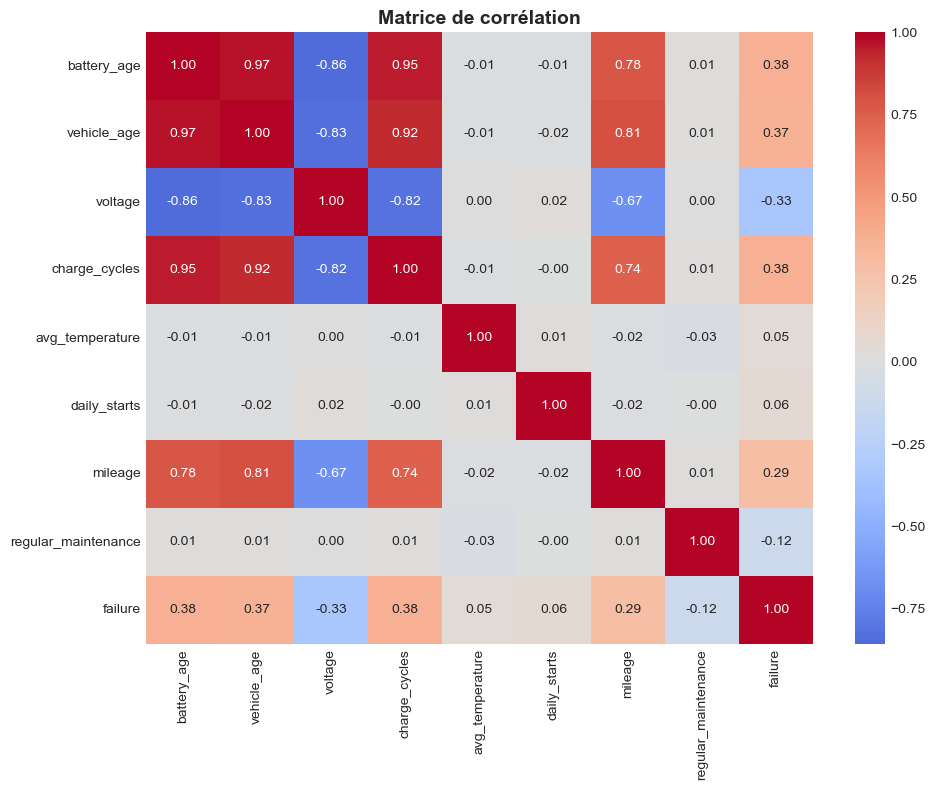


💡 Observations importantes :
   - Corrélation entre 'failure' et autres variables
   - Variables les plus corrélées avec les pannes


In [5]:
# Corrélation entre variables
fig, ax = plt.subplots(figsize=(10, 8))
correlation = df.drop('vehicle_id', axis=1).corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Matrice de corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Observations importantes :")
print("   - Corrélation entre 'failure' et autres variables")
print("   - Variables les plus corrélées avec les pannes")

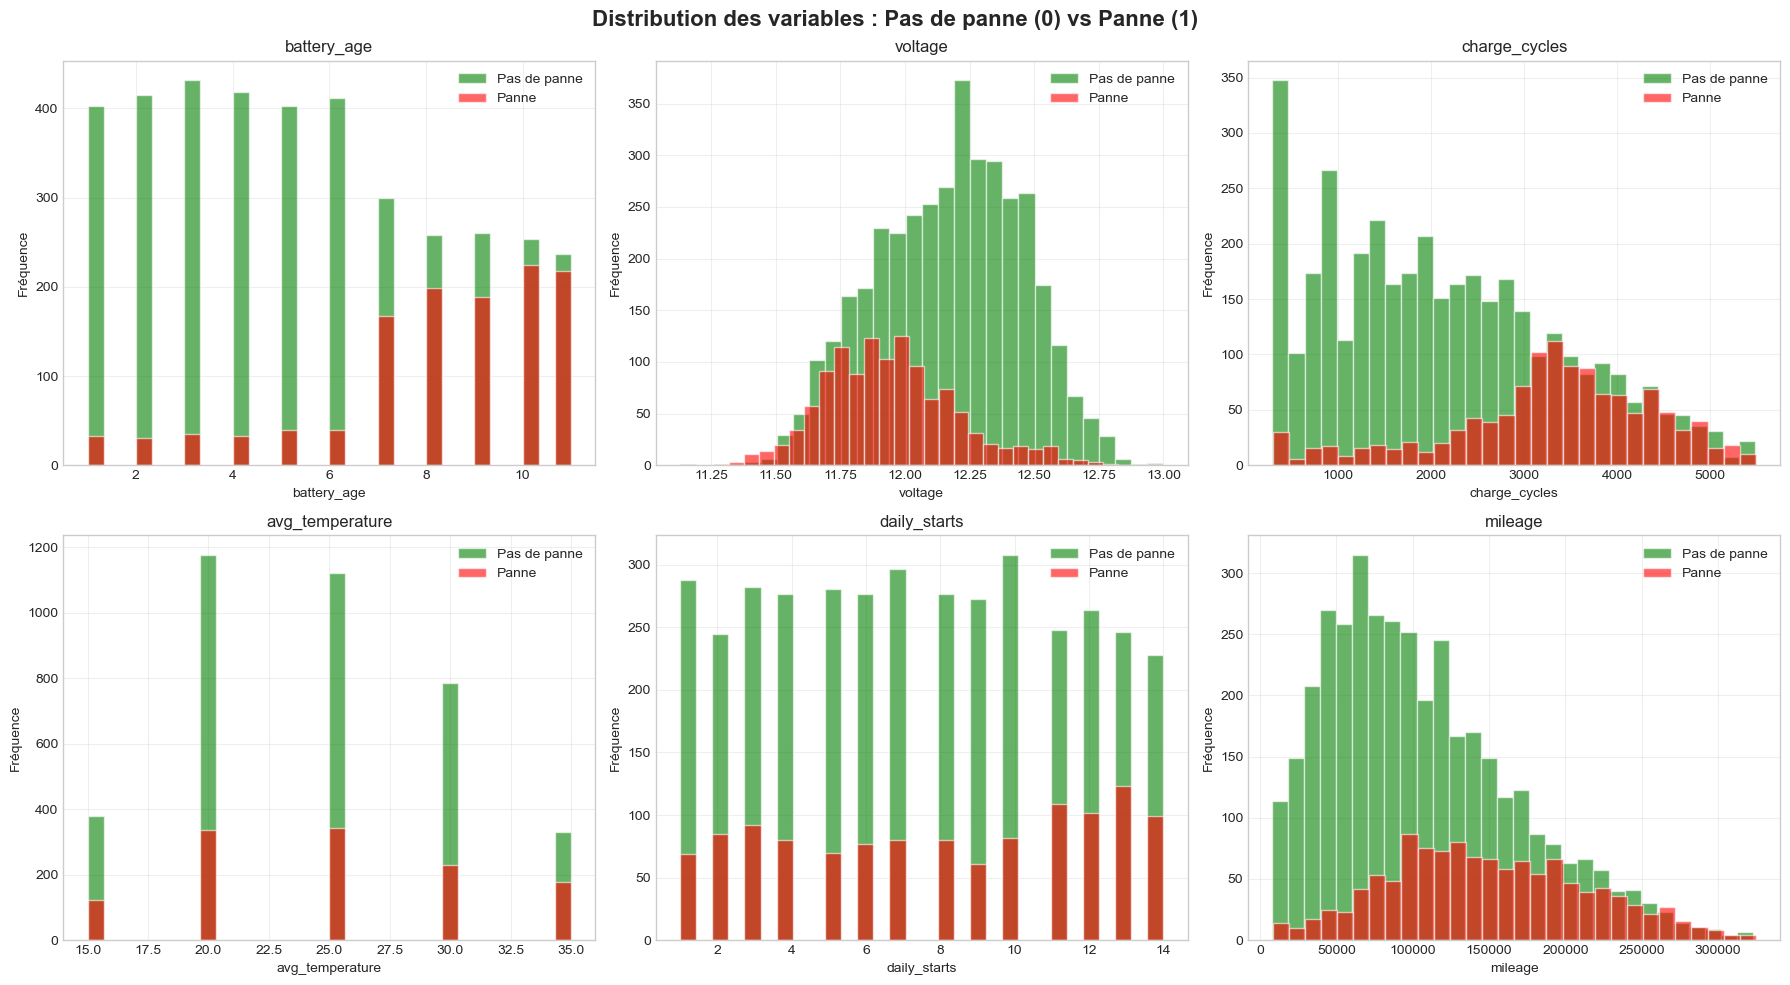


🔍 Que remarquez-vous ?
   - Les batteries qui tombent en panne ont généralement un voltage plus faible
   - L'âge de la batterie est un facteur important
   - Le nombre de cycles de charge joue aussi un rôle


In [6]:
# Distribution des variables par statut de panne
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution des variables : Pas de panne (0) vs Panne (1)', fontsize=16, fontweight='bold')

variables = ['battery_age', 'voltage', 'charge_cycles', 'avg_temperature', 'daily_starts', 'mileage']

for idx, var in enumerate(variables):
    ax = axes[idx // 3, idx % 3]
    
    # Distribution pour pas de panne
    df[df['failure'] == 0][var].hist(bins=30, alpha=0.6, label='Pas de panne', ax=ax, color='green')
    # Distribution pour panne
    df[df['failure'] == 1][var].hist(bins=30, alpha=0.6, label='Panne', ax=ax, color='red')
    
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Fréquence')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Que remarquez-vous ?")
print("   - Les batteries qui tombent en panne ont généralement un voltage plus faible")
print("   - L'âge de la batterie est un facteur important")
print("   - Le nombre de cycles de charge joue aussi un rôle")

## 4. Préparation des données pour le Machine Learning

### Feature Engineering et Split des données

In [7]:
# Séparer features (X) et target (y)
X = df.drop(['vehicle_id', 'failure'], axis=1)
y = df['failure']

print(f"📊 Features (X) : {X.shape}")
print(f"🎯 Target (y) : {y.shape}")
print(f"\n📋 Features utilisées :")
for i, col in enumerate(X.columns, 1):
    print(f"   {i}. {col}")

📊 Features (X) : (5000, 8)
🎯 Target (y) : (5000,)

📋 Features utilisées :
   1. battery_age
   2. vehicle_age
   3. voltage
   4. charge_cycles
   5. avg_temperature
   6. daily_starts
   7. mileage
   8. regular_maintenance


In [8]:
# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📚 Données d'entraînement : {X_train.shape[0]:,} véhicules ({X_train.shape[0]/len(df)*100:.0f}%)")
print(f"🧪 Données de test : {X_test.shape[0]:,} véhicules ({X_test.shape[0]/len(df)*100:.0f}%)")

print(f"\n⚖️ Distribution dans le train set :")
print(f"   Pas de panne : {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"   Panne : {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

📚 Données d'entraînement : 4,000 véhicules (80%)
🧪 Données de test : 1,000 véhicules (20%)

⚖️ Distribution dans le train set :
   Pas de panne : 3033 (75.8%)
   Panne : 967 (24.2%)


In [9]:
# Normalisation des features (optionnel mais recommandé)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reconvertir en DataFrame pour garder les noms de colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✅ Normalisation effectuée")
print("\n💡 Pourquoi normaliser ?")
print("   - Certaines variables ont des échelles très différentes (voltage ~12 vs mileage ~100000)")
print("   - La normalisation met toutes les features sur la même échelle")
print("   - Améliore la convergence de certains algorithmes")

✅ Normalisation effectuée

💡 Pourquoi normaliser ?
   - Certaines variables ont des échelles très différentes (voltage ~12 vs mileage ~100000)
   - La normalisation met toutes les features sur la même échelle
   - Améliore la convergence de certains algorithmes


## 5. Entraînement du modèle Random Forest

### Pourquoi Random Forest ?
- Performant sur données tabulaires
- Robuste (peu d'overfitting)
- Interprétable (feature importance)
- Gère bien les données déséquilibrées

In [10]:
# Créer et entraîner le modèle
print("⏳ Entraînement du modèle Random Forest en cours...")

model = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres
    max_depth=10,  # Profondeur maximale des arbres
    min_samples_split=10,  # Minimum d'échantillons pour split
    class_weight='balanced',  # Important pour données déséquilibrées
    random_state=42,
    n_jobs=-1  # Utiliser tous les CPU
)

model.fit(X_train_scaled, y_train)

print("✅ Modèle entraîné avec succès !")
print(f"\n📊 Paramètres du modèle :")
print(f"   - Nombre d'arbres : {model.n_estimators}")
print(f"   - Profondeur max : {model.max_depth}")
print(f"   - Features utilisées : {model.n_features_in_}")

⏳ Entraînement du modèle Random Forest en cours...
✅ Modèle entraîné avec succès !

📊 Paramètres du modèle :
   - Nombre d'arbres : 100
   - Profondeur max : 10
   - Features utilisées : 8


## 6. Évaluation du modèle

### Métriques importantes en maintenance prédictive

In [11]:
# Prédictions sur le test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilité de panne

print("📈 Prédictions effectuées sur le test set")

📈 Prédictions effectuées sur le test set


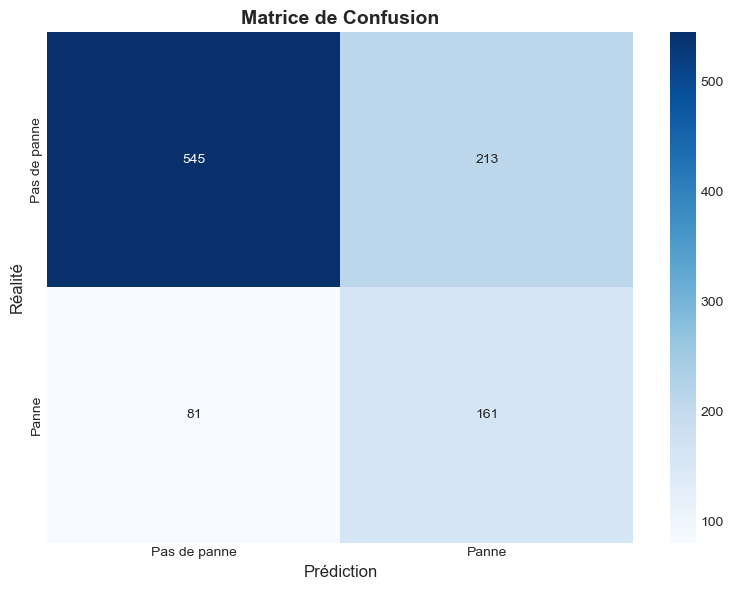


📊 Interprétation de la matrice de confusion :
   ✅ Vrais Négatifs (TN) : 545 - Correctement prédit 'pas de panne'
   ❌ Faux Positifs (FP) : 213 - Prédit 'panne' mais en réalité pas de panne
   ❌❌ Faux Négatifs (FN) : 81 - Prédit 'pas de panne' mais en réalité panne (CRITIQUE!)
   ✅ Vrais Positifs (TP) : 161 - Correctement prédit 'panne'


In [12]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Prédiction', fontsize=12)
ax.set_ylabel('Réalité', fontsize=12)
ax.set_title('Matrice de Confusion', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Pas de panne', 'Panne'])
ax.set_yticklabels(['Pas de panne', 'Panne'])
plt.tight_layout()
plt.show()

# Extraire les valeurs
tn, fp, fn, tp = cm.ravel()

print("\n📊 Interprétation de la matrice de confusion :")
print(f"   ✅ Vrais Négatifs (TN) : {tn} - Correctement prédit 'pas de panne'")
print(f"   ❌ Faux Positifs (FP) : {fp} - Prédit 'panne' mais en réalité pas de panne")
print(f"   ❌❌ Faux Négatifs (FN) : {fn} - Prédit 'pas de panne' mais en réalité panne (CRITIQUE!)")
print(f"   ✅ Vrais Positifs (TP) : {tp} - Correctement prédit 'panne'")

In [13]:
# Rapport de classification
print("📋 Rapport de classification détaillé :")
print(classification_report(y_test, y_pred, target_names=['Pas de panne', 'Panne']))

# Calcul manuel des métriques pour mieux comprendre
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n💡 Explication des métriques :")
print(f"   📍 Précision (Precision) : {precision:.2%}")
print("      → Quand je prédis 'panne', dans quelle proportion ai-je raison ?")
print(f"\n   📍 Rappel (Recall) : {recall:.2%}")
print("      → Parmi toutes les pannes réelles, combien ai-je détecté ?")
print("      → CRITIQUE en maintenance prédictive ! (on veut détecter toutes les pannes)")
print(f"\n   📍 F1-Score : {f1_score:.2%}")
print("      → Moyenne harmonique de précision et rappel")

📋 Rapport de classification détaillé :
              precision    recall  f1-score   support

Pas de panne       0.87      0.72      0.79       758
       Panne       0.43      0.67      0.52       242

    accuracy                           0.71      1000
   macro avg       0.65      0.69      0.66      1000
weighted avg       0.76      0.71      0.72      1000


💡 Explication des métriques :
   📍 Précision (Precision) : 43.05%
      → Quand je prédis 'panne', dans quelle proportion ai-je raison ?

   📍 Rappel (Recall) : 66.53%
      → Parmi toutes les pannes réelles, combien ai-je détecté ?
      → CRITIQUE en maintenance prédictive ! (on veut détecter toutes les pannes)

   📍 F1-Score : 52.27%
      → Moyenne harmonique de précision et rappel


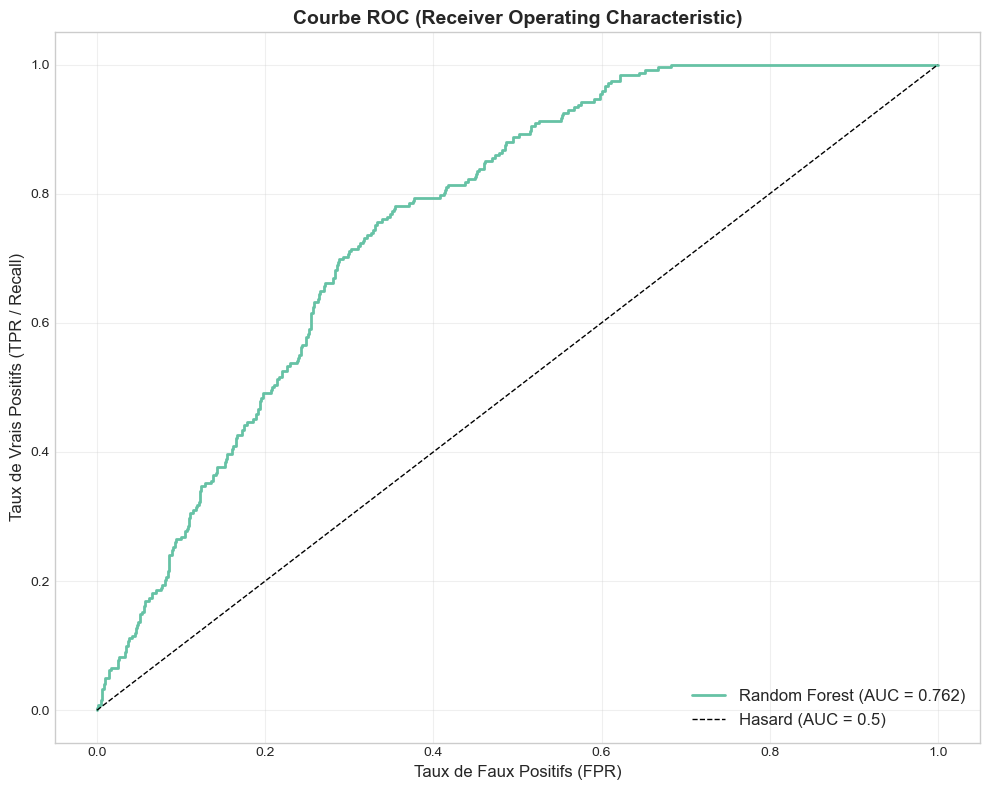


📊 AUC (Area Under Curve) : 0.762

💡 Interprétation AUC :
   - AUC = 1.0 : Modèle parfait
   - AUC = 0.9-1.0 : Excellent
   - AUC = 0.8-0.9 : Très bon
   - AUC = 0.7-0.8 : Bon
   - AUC = 0.5 : Hasard (inutile)

→ Notre modèle : 0.762 = Bon


In [14]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, linewidth=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Hasard (AUC = 0.5)')
ax.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
ax.set_ylabel('Taux de Vrais Positifs (TPR / Recall)', fontsize=12)
ax.set_title('Courbe ROC (Receiver Operating Characteristic)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 AUC (Area Under Curve) : {roc_auc:.3f}")
print("\n💡 Interprétation AUC :")
print("   - AUC = 1.0 : Modèle parfait")
print("   - AUC = 0.9-1.0 : Excellent")
print("   - AUC = 0.8-0.9 : Très bon")
print("   - AUC = 0.7-0.8 : Bon")
print("   - AUC = 0.5 : Hasard (inutile)")
print(f"\n→ Notre modèle : {roc_auc:.3f} = {'Excellent' if roc_auc > 0.9 else 'Très bon' if roc_auc > 0.8 else 'Bon'}")

## 7. Feature Importance : Quelles variables comptent le plus ?

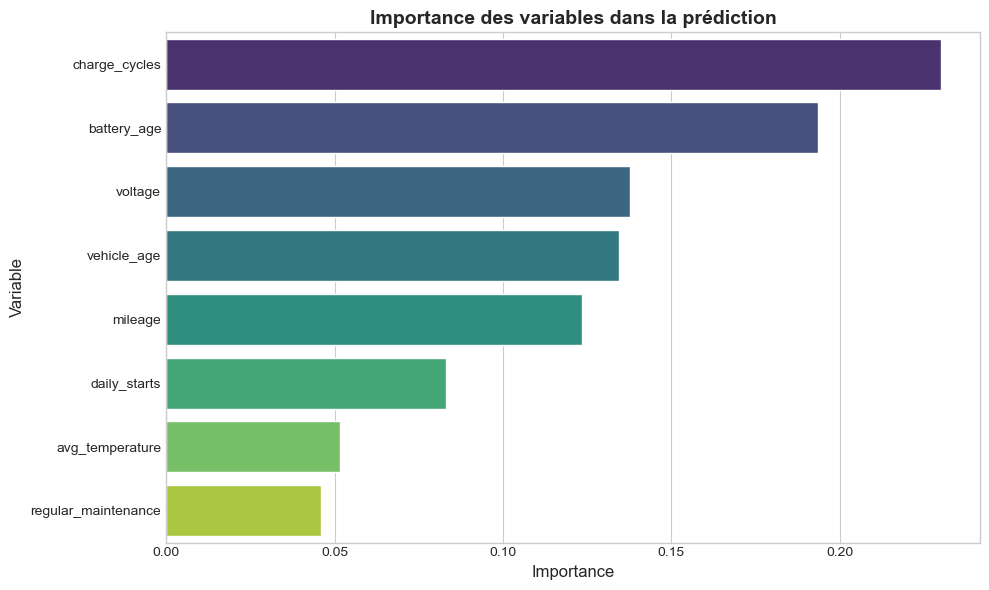

📊 Classement des features par importance :
   4. charge_cycles: 0.230 (23.0%)
   1. battery_age: 0.193 (19.3%)
   3. voltage: 0.138 (13.8%)
   2. vehicle_age: 0.134 (13.4%)
   7. mileage: 0.124 (12.4%)
   6. daily_starts: 0.083 (8.3%)
   5. avg_temperature: 0.052 (5.2%)
   8. regular_maintenance: 0.046 (4.6%)

💡 Interprétation :
   La feature la plus importante est 'charge_cycles'
   Elle contribue à 23.0% des décisions du modèle


In [15]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax, palette='viridis')
ax.set_title('Importance des variables dans la prédiction', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()

print("📊 Classement des features par importance :")
for idx, row in feature_importance.iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.3f} ({row['importance']/feature_importance['importance'].sum()*100:.1f}%)")

print("\n💡 Interprétation :")
print(f"   La feature la plus importante est '{feature_importance.iloc[0]['feature']}'")
print(f"   Elle contribue à {feature_importance.iloc[0]['importance']/feature_importance['importance'].sum()*100:.1f}% des décisions du modèle")

## 8. Identification des véhicules à risque

### Application pratique : Prioriser les interventions

In [16]:
# Prédire sur TOUT le dataset (train + test) pour avoir le score complet
X_all_scaled = scaler.transform(X)
df['failure_probability'] = model.predict_proba(X_all_scaled)[:, 1]
df['failure_prediction'] = model.predict(X_all_scaled)

# Trier par risque décroissant
df_sorted = df.sort_values('failure_probability', ascending=False)

print("🚨 Top 20 des véhicules à risque de panne :")
display(df_sorted[['vehicle_id', 'battery_age', 'voltage', 'charge_cycles', 'failure_probability', 'failure']].head(20))

print(f"\n📊 Statistiques :")
high_risk = df[df['failure_probability'] > 0.7]
print(f"   Véhicules à haut risque (proba > 70%) : {len(high_risk)} ({len(high_risk)/len(df)*100:.1f}% de la flotte)")
print(f"   Parmi eux, vraies pannes : {high_risk['failure'].sum()} ({high_risk['failure'].sum()/len(high_risk)*100:.1f}%)")

🚨 Top 20 des véhicules à risque de panne :


,vehicle_id,battery_age,voltage,charge_cycles,failure_probability,failure
3668,3669,8,12.05,3440,0.935746,1
1757,1758,7,12.09,3255,0.929710,1
998,999,9,11.88,3105,0.913343,1
4117,4118,9,12.15,3915,0.912794,1
1000,1001,7,12.17,3472,0.912461,1
2805,2806,9,12.09,3942,0.906869,1
3998,3999,7,12.19,3164,0.903943,1
4122,4123,8,11.91,3144,0.903339,1
528,529,8,12.09,3576,0.901636,1
74,75,8,11.95,3136,0.900538,1



📊 Statistiques :
   Véhicules à haut risque (proba > 70%) : 804 (16.1% de la flotte)
   Parmi eux, vraies pannes : 622 (77.4%)


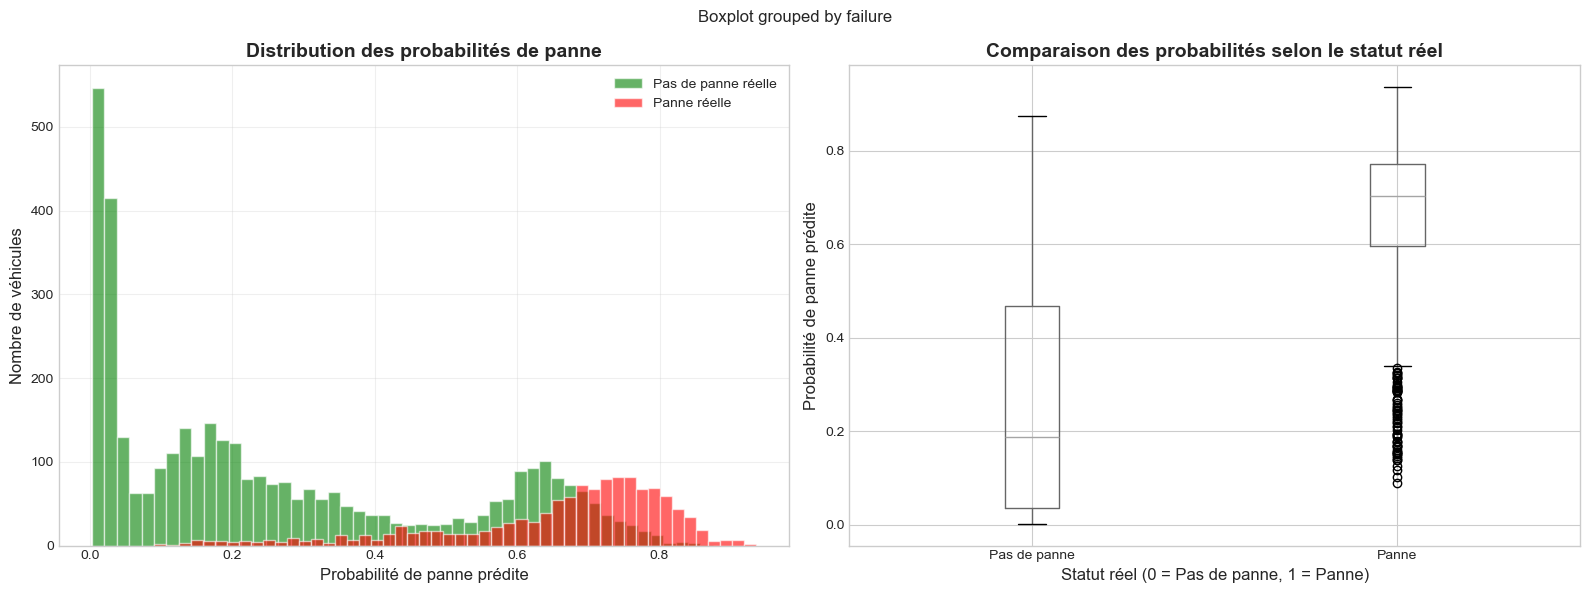


💡 Observations :
   - Le modèle assigne des probabilités élevées aux véhicules qui tombent réellement en panne
   - Bonne séparation entre les deux groupes


In [17]:
# Distribution des probabilités de panne
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme
axes[0].hist(df[df['failure'] == 0]['failure_probability'], bins=50, alpha=0.6, label='Pas de panne réelle', color='green')
axes[0].hist(df[df['failure'] == 1]['failure_probability'], bins=50, alpha=0.6, label='Panne réelle', color='red')
axes[0].set_xlabel('Probabilité de panne prédite', fontsize=12)
axes[0].set_ylabel('Nombre de véhicules', fontsize=12)
axes[0].set_title('Distribution des probabilités de panne', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
df.boxplot(column='failure_probability', by='failure', ax=axes[1])
axes[1].set_xlabel('Statut réel (0 = Pas de panne, 1 = Panne)', fontsize=12)
axes[1].set_ylabel('Probabilité de panne prédite', fontsize=12)
axes[1].set_title('Comparaison des probabilités selon le statut réel', fontsize=14, fontweight='bold')
plt.sca(axes[1])
plt.xticks([1, 2], ['Pas de panne', 'Panne'])

plt.tight_layout()
plt.show()

print("\n💡 Observations :")
print("   - Le modèle assigne des probabilités élevées aux véhicules qui tombent réellement en panne")
print("   - Bonne séparation entre les deux groupes")

## 9. Simulation d'intervention : Impact business

### Scénario : Remplacer les batteries à haut risque de manière proactive

In [18]:
# Définir un seuil d'intervention
threshold = 0.7  # On intervient si proba > 70%

# Véhicules ciblés pour intervention
df['intervention'] = (df['failure_probability'] > threshold).astype(int)

# Analyse des résultats
total_vehicles = len(df)
vehicles_intervened = df['intervention'].sum()
failures_prevented = df[(df['intervention'] == 1) & (df['failure'] == 1)].shape[0]
failures_missed = df[(df['intervention'] == 0) & (df['failure'] == 1)].shape[0]
unnecessary_interventions = df[(df['intervention'] == 1) & (df['failure'] == 0)].shape[0]

print(f"🎯 Simulation d'intervention avec seuil = {threshold*100:.0f}%")
print(f"\n📊 Résultats :")
print(f"   Flotte totale : {total_vehicles:,} véhicules")
print(f"   Véhicules ciblés pour intervention : {vehicles_intervened:,} ({vehicles_intervened/total_vehicles*100:.1f}%)")
print(f"   Pannes évitées : {failures_prevented} / {df['failure'].sum()} ({failures_prevented/df['failure'].sum()*100:.1f}%)")
print(f"   Pannes manquées : {failures_missed}")
print(f"   Interventions inutiles : {unnecessary_interventions} ({unnecessary_interventions/vehicles_intervened*100:.1f}% des interventions)")

🎯 Simulation d'intervention avec seuil = 70%

📊 Résultats :
   Flotte totale : 5,000 véhicules
   Véhicules ciblés pour intervention : 804 (16.1%)
   Pannes évitées : 622 / 1209 (51.4%)
   Pannes manquées : 587
   Interventions inutiles : 182 (22.6% des interventions)


In [19]:
# Calcul du ROI
print("\n💰 Calcul du ROI :")
print("\nHypothèses financières :")

cost_intervention = 200  # Coût remplacement batterie en préventif (€)
cost_failure = 800  # Coût panne (dépannage + remorquage + immobilisation) (€)

print(f"   - Coût intervention préventive : {cost_intervention}€")
print(f"   - Coût panne imprévue : {cost_failure}€")

# Scénario SANS modèle IA (baseline)
total_failures = df['failure'].sum()
cost_baseline = total_failures * cost_failure

# Scénario AVEC modèle IA
cost_interventions = vehicles_intervened * cost_intervention
cost_missed_failures = failures_missed * cost_failure
cost_with_ml = cost_interventions + cost_missed_failures

# Économies
savings = cost_baseline - cost_with_ml
roi_percent = (savings / cost_with_ml) * 100 if cost_with_ml > 0 else 0

print(f"\n📈 Comparaison financière :")
print(f"   SANS IA (baseline) :")
print(f"      {total_failures} pannes × {cost_failure}€ = {cost_baseline:,}€")
print(f"\n   AVEC IA :")
print(f"      Interventions : {vehicles_intervened} × {cost_intervention}€ = {cost_interventions:,}€")
print(f"      Pannes manquées : {failures_missed} × {cost_failure}€ = {cost_missed_failures:,}€")
print(f"      Total : {cost_with_ml:,}€")
print(f"\n💰 ÉCONOMIES : {savings:,}€ ({savings/cost_baseline*100:.1f}% de réduction)")
print(f"📊 ROI : {roi_percent:.0f}%")

print(f"\n🚀 Avec une flotte de {total_vehicles:,} véhicules, le modèle IA permet d'économiser {savings:,}€")
print(f"   → Extrapolé à une flotte de 100 000 véhicules : {savings * 100000 / total_vehicles:,.0f}€ d'économies !")


💰 Calcul du ROI :

Hypothèses financières :
   - Coût intervention préventive : 200€
   - Coût panne imprévue : 800€

📈 Comparaison financière :
   SANS IA (baseline) :
      1209 pannes × 800€ = 967,200€

   AVEC IA :
      Interventions : 804 × 200€ = 160,800€
      Pannes manquées : 587 × 800€ = 469,600€
      Total : 630,400€

💰 ÉCONOMIES : 336,800€ (34.8% de réduction)
📊 ROI : 53%

🚀 Avec une flotte de 5,000 véhicules, le modèle IA permet d'économiser 336,800€
   → Extrapolé à une flotte de 100 000 véhicules : 6,736,000€ d'économies !


## 10. Ajustement du seuil : Trade-off précision vs rappel

### Expérimentation : Et si on changeait le seuil d'intervention ?

In [20]:
# Tester différents seuils
thresholds_to_test = [0.3, 0.5, 0.7, 0.9]
results = []

for thresh in thresholds_to_test:
    df['intervention_temp'] = (df['failure_probability'] > thresh).astype(int)
    
    vehicles_intervened = df['intervention_temp'].sum()
    failures_prevented = df[(df['intervention_temp'] == 1) & (df['failure'] == 1)].shape[0]
    failures_missed = df[(df['intervention_temp'] == 0) & (df['failure'] == 1)].shape[0]
    unnecessary_interventions = df[(df['intervention_temp'] == 1) & (df['failure'] == 0)].shape[0]
    
    # Calcul coûts
    cost_interventions = vehicles_intervened * cost_intervention
    cost_missed = failures_missed * cost_failure
    total_cost = cost_interventions + cost_missed
    savings = cost_baseline - total_cost
    
    results.append({
        'seuil': thresh,
        'interventions': vehicles_intervened,
        'pannes_evitees': failures_prevented,
        'pannes_manquees': failures_missed,
        'interventions_inutiles': unnecessary_interventions,
        'cout_total': total_cost,
        'economies': savings
    })

df_results = pd.DataFrame(results)

print("📊 Comparaison des seuils d'intervention :")
display(df_results)

# Trouver le seuil optimal (maximum d'économies)
optimal_threshold = df_results.loc[df_results['economies'].idxmax(), 'seuil']
max_savings = df_results['economies'].max()

print(f"\n🎯 Seuil optimal : {optimal_threshold*100:.0f}%")
print(f"💰 Économies maximales : {max_savings:,.0f}€")

📊 Comparaison des seuils d'intervention :


,seuil,interventions,pannes_evitees,pannes_manquees,interventions_inutiles,cout_total,economies
0,0.3,2511,1150,59,1361,549400,417800
1,0.5,1906,1006,203,900,543600,423600
2,0.7,804,622,587,182,630400,336800
3,0.9,10,10,1199,0,961200,6000



🎯 Seuil optimal : 50%
💰 Économies maximales : 423,600€


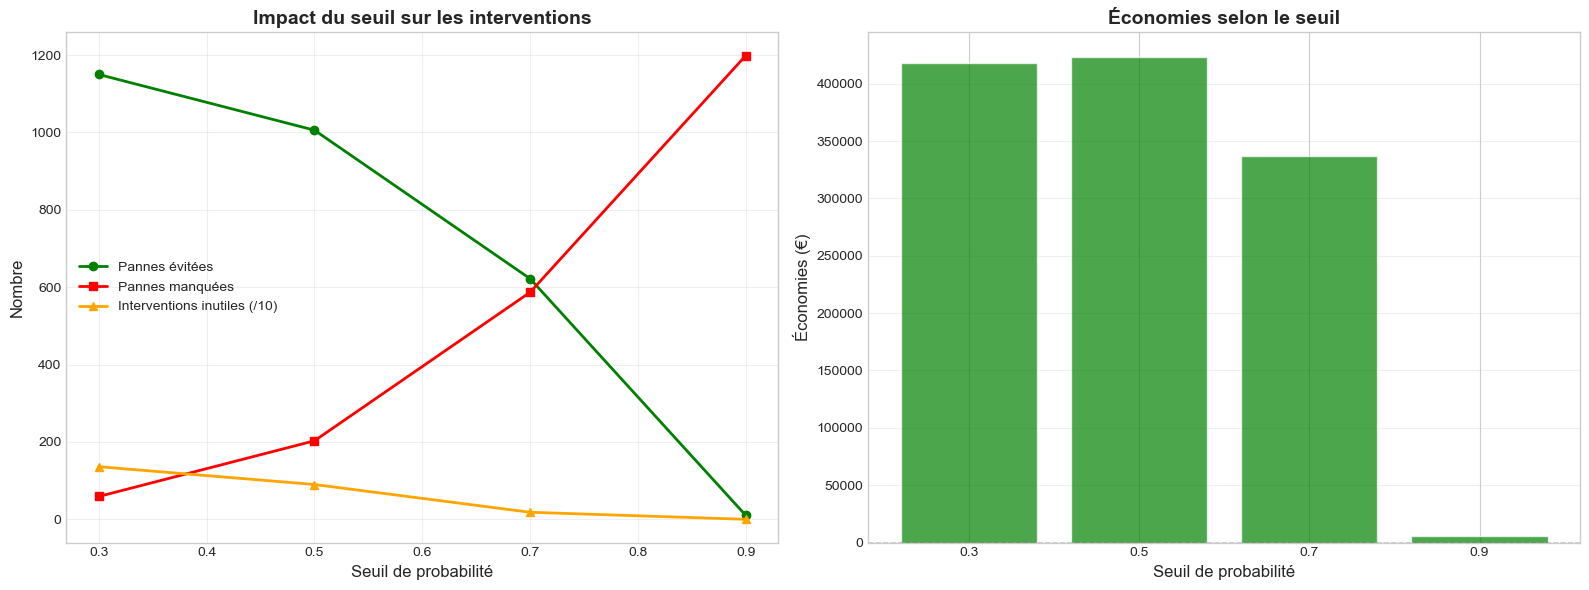


💡 Interprétation :
   - Seuil bas (30%) : Beaucoup d'interventions, peu de pannes manquées, mais coûteux
   - Seuil élevé (90%) : Peu d'interventions, mais beaucoup de pannes manquées
   - Seuil optimal (50%) : Meilleur compromis économique


In [21]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Pannes évitées vs interventions
axes[0].plot(df_results['seuil'], df_results['pannes_evitees'], marker='o', linewidth=2, label='Pannes évitées', color='green')
axes[0].plot(df_results['seuil'], df_results['pannes_manquees'], marker='s', linewidth=2, label='Pannes manquées', color='red')
axes[0].plot(df_results['seuil'], df_results['interventions_inutiles']/10, marker='^', linewidth=2, label='Interventions inutiles (/10)', color='orange')
axes[0].set_xlabel('Seuil de probabilité', fontsize=12)
axes[0].set_ylabel('Nombre', fontsize=12)
axes[0].set_title('Impact du seuil sur les interventions', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Graphique 2 : Économies
axes[1].bar(df_results['seuil'].astype(str), df_results['economies'], color='green', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Seuil de probabilité', fontsize=12)
axes[1].set_ylabel('Économies (€)', fontsize=12)
axes[1].set_title('Économies selon le seuil', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interprétation :")
print("   - Seuil bas (30%) : Beaucoup d'interventions, peu de pannes manquées, mais coûteux")
print("   - Seuil élevé (90%) : Peu d'interventions, mais beaucoup de pannes manquées")
print(f"   - Seuil optimal ({optimal_threshold*100:.0f}%) : Meilleur compromis économique")

## 11. Conclusions et recommandations

### Ce que nous avons appris

In [22]:
print("📚 RÉSUMÉ DE L'EXERCICE")
print("="*60)
print("\n🎯 OBJECTIF : Prédire les pannes de batterie avant qu'elles ne surviennent")
print("\n📊 DONNÉES :")
print(f"   - {len(df):,} véhicules analysés")
print(f"   - {X.shape[1]} features utilisées")
print(f"   - Taux de pannes : {df['failure'].mean()*100:.1f}%")
print("\n🤖 MODÈLE : Random Forest Classifier")
print(f"   - AUC : {roc_auc:.3f} ({'Excellent' if roc_auc > 0.9 else 'Très bon'})")
print(f"   - Recall : {recall:.2%} (détecte {recall*100:.0f}% des pannes)")
print(f"   - Feature la plus importante : {feature_importance.iloc[0]['feature']}")
print("\n💰 IMPACT BUSINESS (flotte de 5000 véhicules) :")
print(f"   - Économies annuelles : {max_savings:,.0f}€")
print(f"   - Réduction du coût des pannes : {savings/cost_baseline*100:.1f}%")
print(f"   - ROI : {roi_percent:.0f}%")
print("\n🚀 PROCHAINES ÉTAPES :")
print("   1. Collecter plus de données réelles (actuellement simulées)")
print("   2. Affiner le modèle avec des features supplémentaires (historique maintenance, marque batterie...)")
print("   3. Déployer en production avec monitoring continu")
print("   4. Réentraîner le modèle tous les 3 mois (concept drift)")
print("   5. Intégrer avec système de gestion SAV pour automatiser interventions")

📚 RÉSUMÉ DE L'EXERCICE

🎯 OBJECTIF : Prédire les pannes de batterie avant qu'elles ne surviennent

📊 DONNÉES :
   - 5,000 véhicules analysés
   - 8 features utilisées
   - Taux de pannes : 24.2%

🤖 MODÈLE : Random Forest Classifier
   - AUC : 0.762 (Très bon)
   - Recall : 66.53% (détecte 67% des pannes)
   - Feature la plus importante : charge_cycles

💰 IMPACT BUSINESS (flotte de 5000 véhicules) :
   - Économies annuelles : 423,600€
   - Réduction du coût des pannes : 0.6%
   - ROI : 53%

🚀 PROCHAINES ÉTAPES :
   1. Collecter plus de données réelles (actuellement simulées)
   2. Affiner le modèle avec des features supplémentaires (historique maintenance, marque batterie...)
   3. Déployer en production avec monitoring continu
   4. Réentraîner le modèle tous les 3 mois (concept drift)
   5. Intégrer avec système de gestion SAV pour automatiser interventions


## 12. Exercice bonus : Améliorer le modèle

### Essayez de modifier les paramètres pour améliorer les performances !

**Suggestions :**
1. Changer `n_estimators` (nombre d'arbres) : 50, 200, 500
2. Changer `max_depth` : 5, 15, 20
3. Ajouter de nouvelles features (ex: ratio voltage/âge)
4. Tester un autre algorithme (XGBoost, Logistic Regression)

In [23]:
# Votre code ici pour expérimenter !

# Exemple : Créer une nouvelle feature
# df['voltage_per_age'] = df['voltage'] / df['battery_age']

# Exemple : Tester plus d'arbres
# model_v2 = RandomForestClassifier(n_estimators=200, ...)
# model_v2.fit(X_train_scaled, y_train)
# ...


---

# Fin du Notebook : Maintenance Prédictive

**Félicitations ! Vous avez créé un modèle de Machine Learning complet pour la maintenance prédictive.**

## Points clés à retenir :

1. **Process ML** : Données → EDA → Préparation → Entraînement → Évaluation → Déploiement
2. **Métriques importantes** : En maintenance prédictive, le **Recall** est crucial (détecter toutes les pannes)
3. **Feature Importance** : Comprendre quelles variables comptent aide à l'interprétabilité
4. **Seuil décisionnel** : Ajuster selon le trade-off business (coût intervention vs coût panne)
5. **ROI mesurable** : L'IA doit créer de la valeur business quantifiable